+ 分布式数据并行时，模型参数和优化器状态每张卡都会拷贝一份
  + DDP始终在卡间维持每个模型的参数和优化器状态的一致
+ 首先对batch进行数据分发，然后在每一张卡上单独进行前向和后向传播，这时每张卡上都会有一个局部的梯度，之后便是需要将所有的梯度聚合到一块，求平均之后再分发到每张卡上进行模型参数和优化器状态的更新，而最关键的部分便是如何在多张卡中进行通信：
  + ps-worker架构：
    即选择CPU或者其中一个GPU作为参数服务器(parameter server)，ps会在每次训练中接收所有其他worker的数据，在ps上进行处理过后再将处理后的数据分发到所有的worker上，以此进行同步，若选择CPU，那么GPU和CPU之间的通信将会使用PCIe，当使用GPU作为ps时，GPU和GPU的通信使用NVLink进行通信，这种方法的瓶颈就在于ps结点的网络带宽：

    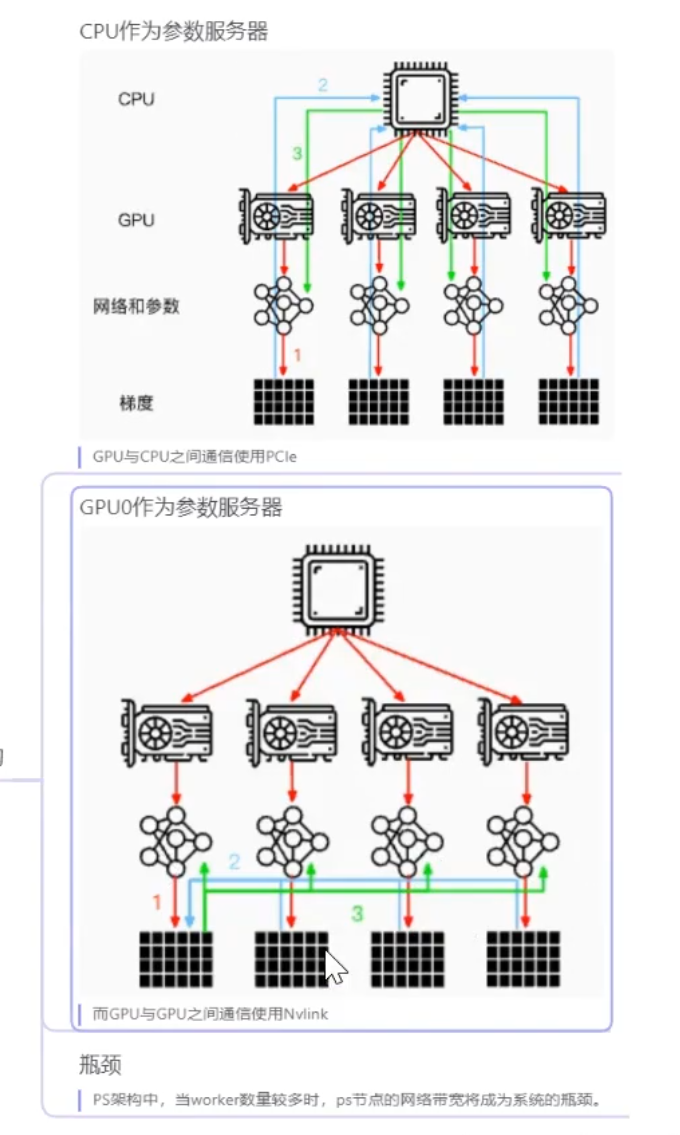
  
  + ring-allreduce架构：
    首先将每张串成一个环形，且每个GPU只能向自己的后继结点发送数据，只能接受来自前继结点的数据，且ring-allreduce算法一共分为两步：
      + scatter-reduce：
        首先将每张GPU的数据按照GPU的数量进行划分成块，然后进行(N-1)次相邻GPU结点的数据交换，每次GPU只发送其中的一块，接收到数据的GPU会把本地对应的块数据进行累加，重复N-1次之后，每张GPU上都会有一个完整的数据块：

        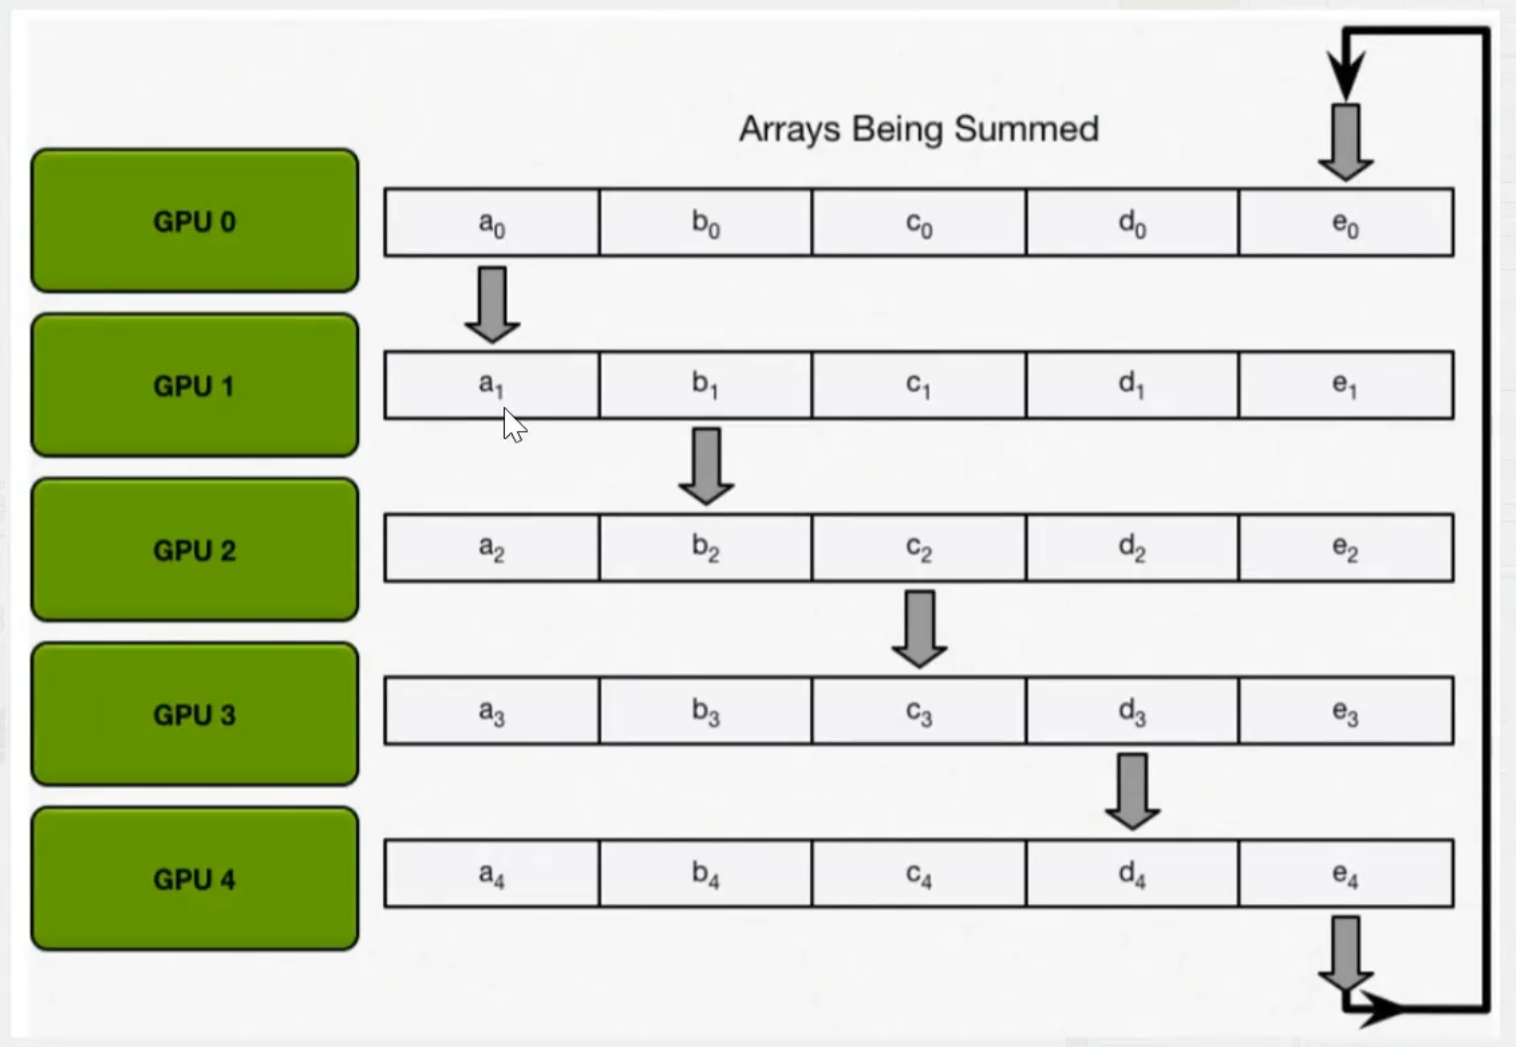 

        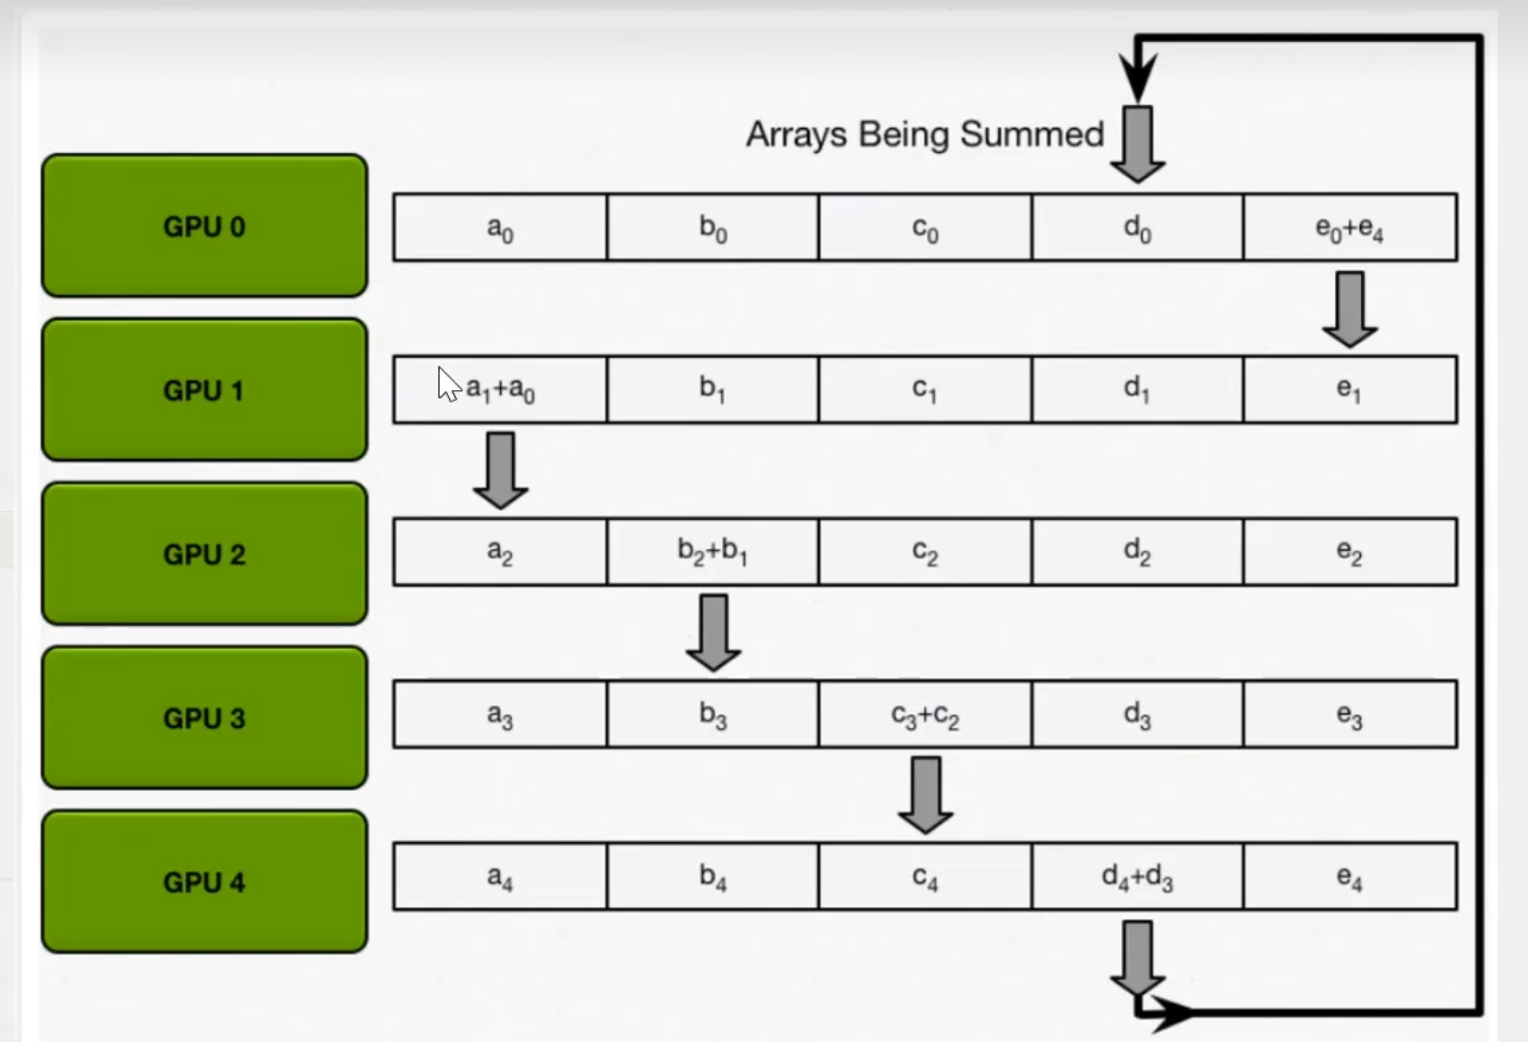

        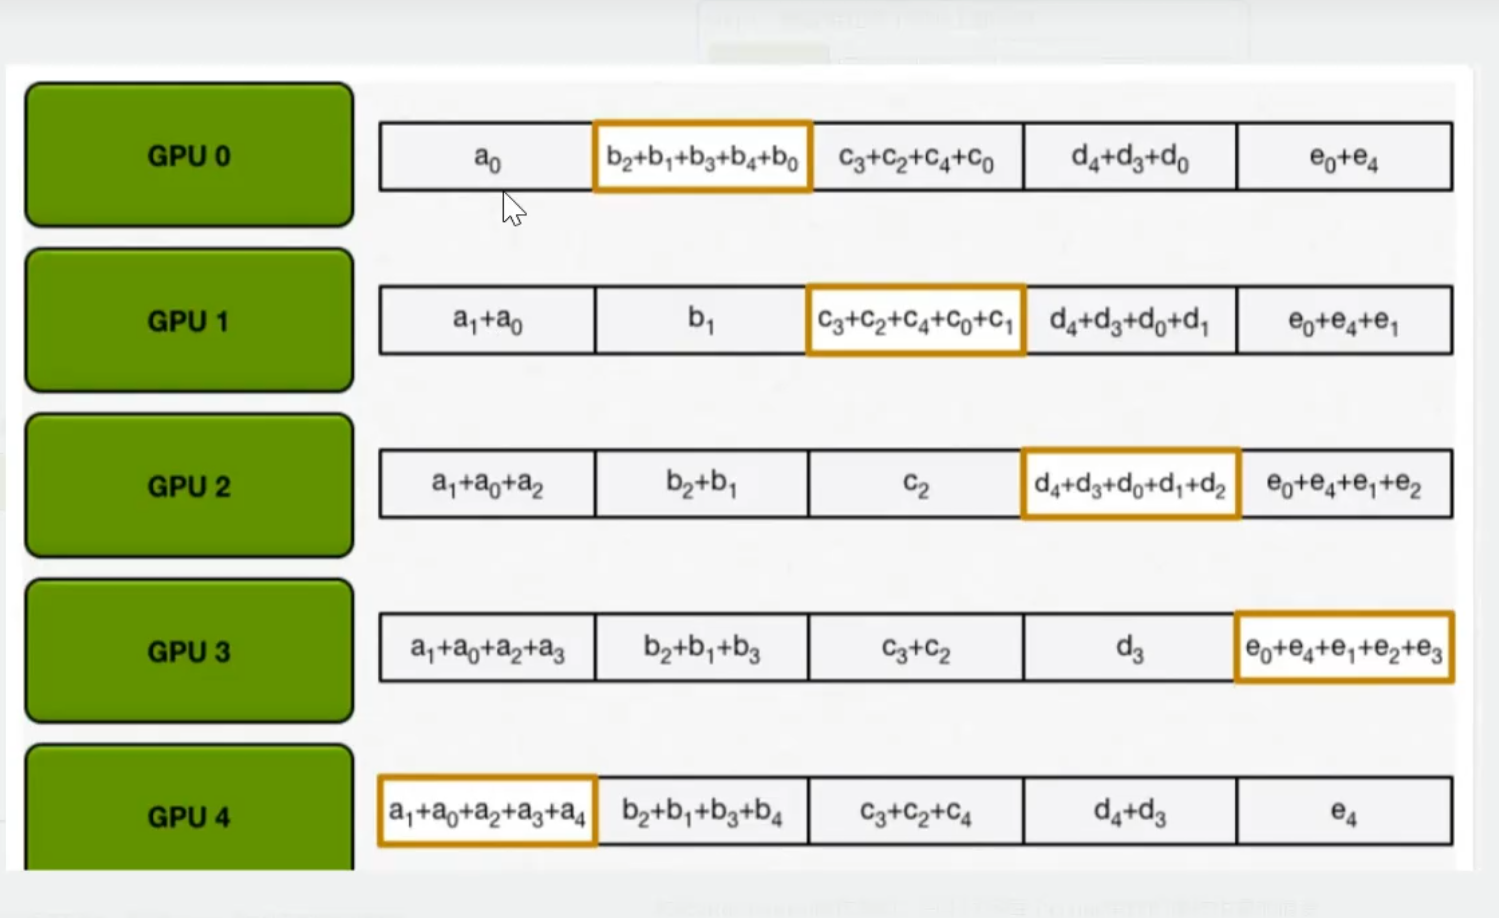

      + all-gather：
        每张GPU都会将自己所持有的完整数据块发送给下一个结点，且每张GPU在接收到完整数据块之后不再是相加，而是直接把对应数据块替换掉，这样重复N-1次之后，每张卡都持有了完整且相同的的数据

        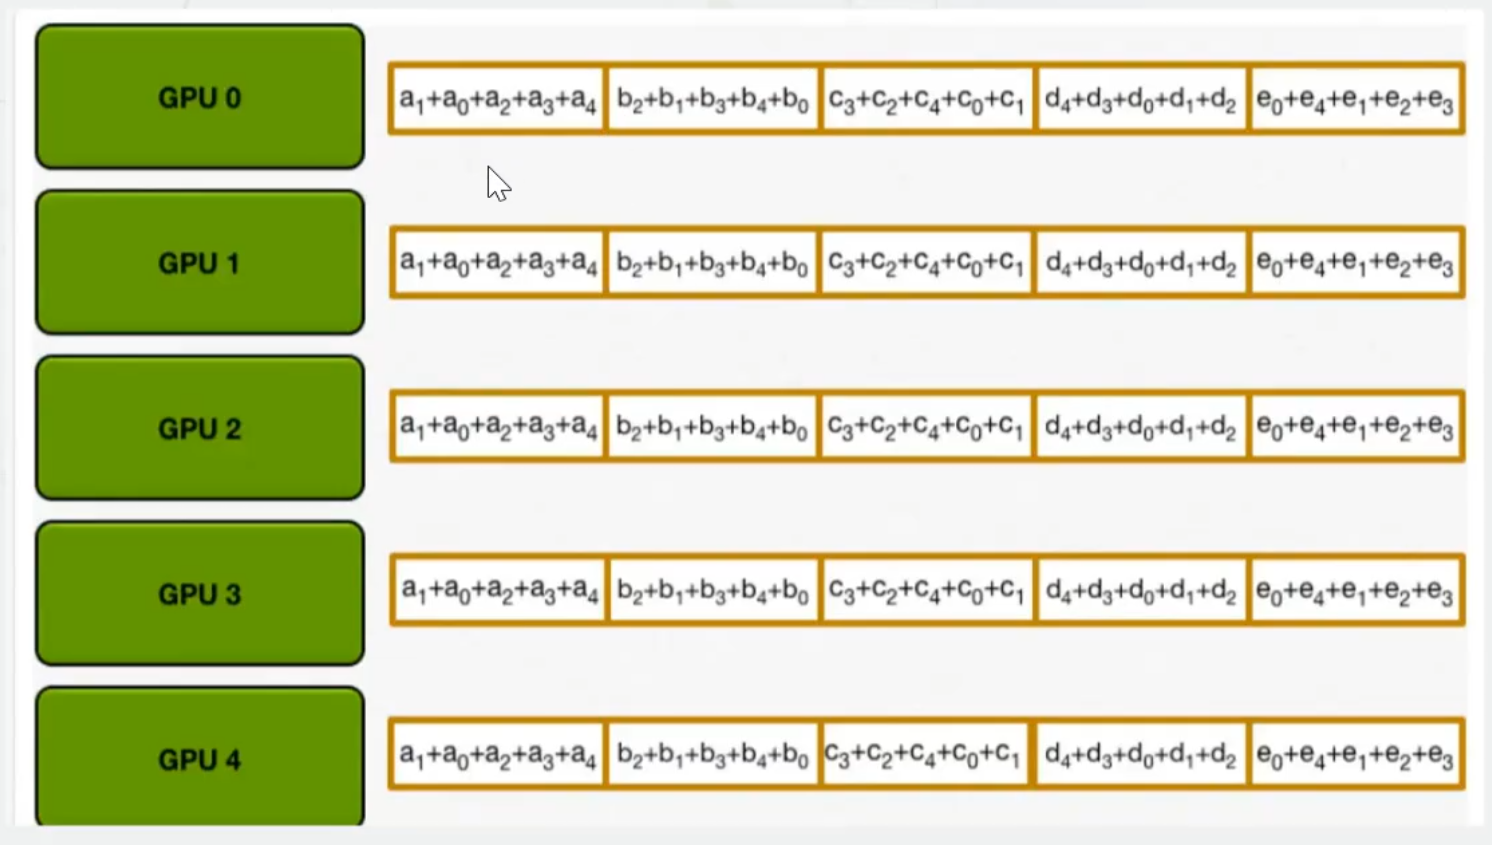

+ 一些术语：
  + world和world_size：

    world是指所有用于分布式训练的进程，一般而言通常一个进程对应一个GPU，world_size就是指进程数量，因此也一般指GPU的数量
  
  + rank
  
    rank是用来标识进程的一个不重复的ID，用于识别进程，因为进程间需要通信

In [1]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

In [2]:
world_size = torch.cuda.device_count()
world_size

2

In [3]:
def ddp_setup(rank, world_size):
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12355"
    
    init_process_group(backend="nccl", rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)


In [4]:
class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 train_dataloader: DataLoader,
                 optimizer: torch.optim.Optimizer,
                 gpu_id: int) -> None:
        self.gpu_id = gpu_id
        self.model = model
        self.train_dataloader = train_dataloader
        self.optimizer = optimizer
        self.model = model.to(gpu_id)
    
    def _run_batch(self, xs, ys):
        self.optimizer.zero_grad()
        output = self.model(xs)
        loss = F.cross_entropy(output, ys)
        # DDP已经把前向和后向传播中的细节封装好了，不需要额外操作
        loss.backward()
        self.optimizer.step()
    
    def _run_epoch(self, epoch):
        batch_size = len(next(iter(self.train_dataloader))[0])
        print(f"GPU:{self.gpu_id}, Epoch {epoch} start, batch size: {batch_size}, Steps: {len(self.train_dataloader)}")
        for step, (xs, ys) in enumerate(self.train_dataloader):
            xs = xs.to(self.gpu_id)
            ys = ys.to(self.gpu_id)
            self._run_batch(xs, ys)
    
    def train(self, max_epoch):
        for epoch in range(max_epoch):
            self._run_epoch(epoch)
        
        
        

In [5]:
class MyTrainDataset(Dataset):
    def __init__(self, size):
        # super().__init__()
        self.size = size
        self.data = [(torch.rand(20), torch.rand(1)) for _ in range(size)]

    def __len__(self):
        return self.size
    
    def __getitem__(self, index):
        return self.data[index]
        

In [6]:
train_dataset = MyTrainDataset(2048)
train_dataset[0]

(tensor([0.6568, 0.7612, 0.9563, 0.9584, 0.1834, 0.6800, 0.9357, 0.5220, 0.6876,
         0.9020, 0.2747, 0.4540, 0.1128, 0.3106, 0.2467, 0.3935, 0.8879, 0.9430,
         0.4428, 0.5285]),
 tensor([0.7559]))

In [7]:
def main(rank, world_size, max_epochs, batch_size):
    ddp_setup(rank, world_size)
    train_dataset = MyTrainDataset(2048)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, sampler=DistributedSampler(train_dataset))
    model = torch.nn.Linear(20, 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    
    trainer = Trainer(model, train_dataloader, optimizer, rank)
    trainer.train(max_epochs)
    
    destroy_process_group()

In [ ]:
!python ddp_gpus.py --max_epochs 5 --batch_size 32
# 可以看出每一个epoch是串行的，但是前向和后向传播是并行的
# 使用nvidia-smi可以查看GPU的使用情况，可以发现两张卡的显存占用一致

[GPU: 1] Epoch: 0 | Batchsize: 32 | Steps: 32
[GPU: 0] Epoch: 0 | Batchsize: 32 | Steps: 32
[GPU: 0] Epoch: 1 | Batchsize: 32 | Steps: 32
[GPU: 1] Epoch: 1 | Batchsize: 32 | Steps: 32
[GPU: 0] Epoch: 2 | Batchsize: 32 | Steps: 32
[GPU: 1] Epoch: 2 | Batchsize: 32 | Steps: 32
[GPU: 0] Epoch: 3 | Batchsize: 32 | Steps: 32
[GPU: 1] Epoch: 3 | Batchsize: 32 | Steps: 32
[GPU: 0] Epoch: 4 | Batchsize: 32 | Steps: 32[GPU: 1] Epoch: 4 | Batchsize: 32 | Steps: 32



In [ ]:
!torchrun --nproc-per-node=2 --master_port=12355 ddp_gpus_torchrun.py --max_epochs 5 --batch_size 32
# 可以看出使用torchrun可以简化代码，不需要使用mp.spawn方法

W0419 08:32:10.128000 73780 site-packages/torch/distributed/run.py:793] 
W0419 08:32:10.128000 73780 site-packages/torch/distributed/run.py:793] *****************************************
W0419 08:32:10.128000 73780 site-packages/torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0419 08:32:10.128000 73780 site-packages/torch/distributed/run.py:793] *****************************************
local_rank: 1, world_size: 2
local_rank: 0, world_size: 2
[GPU: 1] Epoch: 0 | Batchsize: 32 | Steps: 32
[GPU: 0] Epoch: 0 | Batchsize: 32 | Steps: 32
[GPU: 0] Epoch: 1 | Batchsize: 32 | Steps: 32
[GPU: 1] Epoch: 1 | Batchsize: 32 | Steps: 32
[GPU: 0] Epoch: 2 | Batchsize: 32 | Steps: 32
[GPU: 1] Epoch: 2 | Batchsize: 32 | Steps: 32
[GPU: 0] Epoch: 3 | Batchsize: 32 | Steps: 32
[GPU: 1] Epoch: 3 | Batchsize: 32 | S